In [2]:
 import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from google.colab import files

# Setting up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CIFAR-10 dataset loading and transforming
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:03<00:00, 43228388.17it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Epoch 1 - Train loss: 1.773, Train acc: 0.369, Val acc: 0.424
Epoch 2 - Train loss: 1.598, Train acc: 0.432, Val acc: 0.445
Epoch 3 - Train loss: 1.512, Train acc: 0.468, Val acc: 0.463
Epoch 4 - Train loss: 1.452, Train acc: 0.490, Val acc: 0.469
Epoch 5 - Train loss: 1.401, Train acc: 0.509, Val acc: 0.479
Epoch 6 - Train loss: 1.355, Train acc: 0.526, Val acc: 0.495
Epoch 7 - Train loss: 1.322, Train acc: 0.538, Val acc: 0.477
Epoch 8 - Train loss: 1.292, Train acc: 0.549, Val acc: 0.493
Epoch 9 - Train loss: 1.251, Train acc: 0.563, Val acc: 0.497
Epoch 10 - Train loss: 1.220, Train acc: 0.573, Val acc: 0.507
Epoch 11 - Train loss: 1.189, Train acc: 0.587, Val acc: 0.490
Epoch 12 - Train loss: 1.171, Train acc: 0.593, Val acc: 0.490
Epoch 13 - Train loss: 1.132, Train acc: 0.608, Val acc: 0.500
Epoch 14 - Train loss: 1.109, Train acc: 0.618, Val acc: 0.498
Epoch 15 - Train loss: 1.093, Train acc: 0.624, Val acc: 0.499
Epoch 16 - Train loss: 1.069, Train acc: 0.632, Val acc: 0.495
E

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

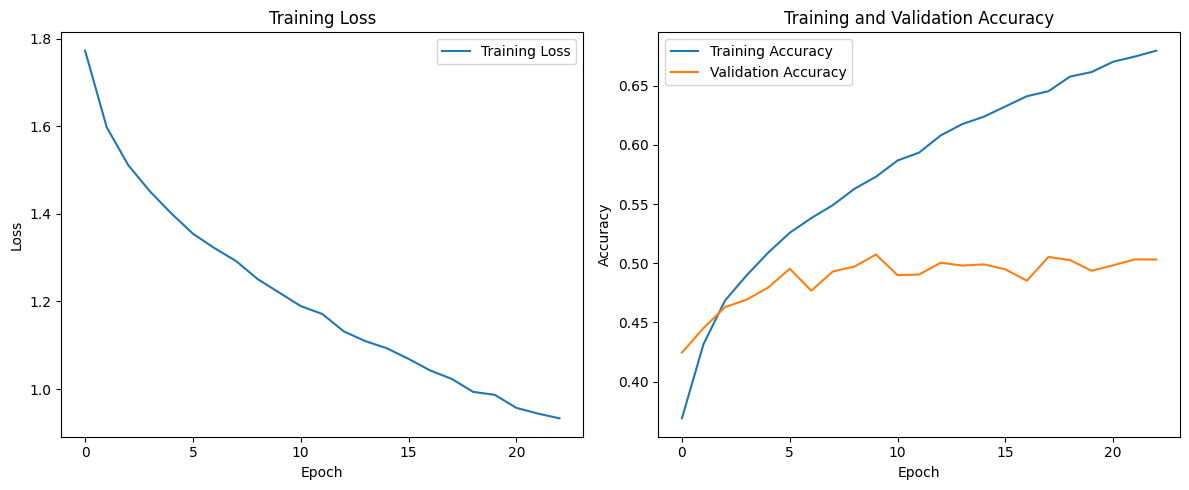

In [42]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
       self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = MLP().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 23
train_losses, train_accs, val_accs = [], [], []

for epoch in range(epochs):
    running_loss = 0.0
    correct, total = 0, 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(trainloader))
    train_acc = correct / total
    train_accs.append(train_acc)

    # Validation accuracy
    correct, total = 0, 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = correct / total
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1} - Train loss: {running_loss/len(trainloader):.3f}, Train acc: {train_acc:.3f}, Val acc: {val_acc:.3f}")

# Saving the model parameters
torch.save(model.state_dict(), '/mnt/data/cifar10_mlp_model.pth')

# Evaluating the model
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

# Plotting the training results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.savefig('trainloss.png')
files.download('trainloss.png')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig('train_vali_Accu.png')
files.download('train_vali_Accu.png')

plt.tight_layout()
files.download('/mnt/data/cifar10_mlp_model.pth')

In [4]:
!mkdir /mnt/data

mkdir: cannot create directory ‘/mnt/data’: File exists


The above training overfits the model as you see the validation loss decreases and increases and that can be a sign that model is memorizing and not generalizing or overfitting. Reduced the complexity in the below code to 256 , 64, 10 neuron

Epoch 1 - Train loss: 1.760, Train acc: 0.375, Val acc: 0.422
Epoch 2 - Train loss: 1.593, Train acc: 0.439, Val acc: 0.441
Epoch 3 - Train loss: 1.528, Train acc: 0.459, Val acc: 0.463
Epoch 4 - Train loss: 1.470, Train acc: 0.482, Val acc: 0.471
Epoch 5 - Train loss: 1.424, Train acc: 0.501, Val acc: 0.468
Epoch 6 - Train loss: 1.386, Train acc: 0.514, Val acc: 0.443
Epoch 7 - Train loss: 1.358, Train acc: 0.529, Val acc: 0.483
Epoch 8 - Train loss: 1.321, Train acc: 0.538, Val acc: 0.466
Epoch 9 - Train loss: 1.294, Train acc: 0.547, Val acc: 0.474
Epoch 10 - Train loss: 1.264, Train acc: 0.555, Val acc: 0.482
Epoch 11 - Train loss: 1.240, Train acc: 0.564, Val acc: 0.479
Epoch 12 - Train loss: 1.214, Train acc: 0.576, Val acc: 0.473
Epoch 13 - Train loss: 1.195, Train acc: 0.580, Val acc: 0.477
Epoch 14 - Train loss: 1.171, Train acc: 0.592, Val acc: 0.488
Epoch 15 - Train loss: 1.147, Train acc: 0.595, Val acc: 0.487
Epoch 16 - Train loss: 1.130, Train acc: 0.603, Val acc: 0.481
E

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Precision: 0.4956
Recall: 0.4855
F1 Score: 0.4884
Confusion Matrix:
[[451  23  89  32 129  11  15  40 176  34]
 [ 78 576  10  37  37   6  13   9  77 157]
 [ 57  18 420 100 171  69  84  41  27  13]
 [ 21  21  65 307 115 263 111  33  22  42]
 [ 46  16 131 104 475  46  87  63  18  14]
 [ 10  13  97 217  79 428  55  66  16  19]
 [ 16  21  90 113 133  37 543  16  11  20]
 [ 27  14  60  80 124 100  22 517  16  40]
 [ 83  59  19  45  55  16   7   7 658  51]
 [ 82 152  16  58  30  25  12  64  81 480]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

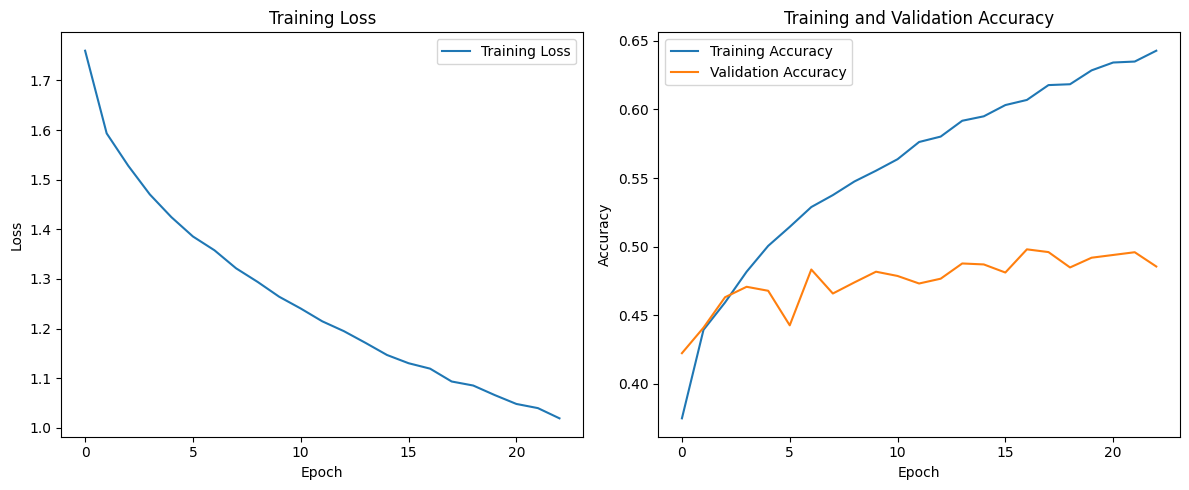

In [5]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # Reducing the number of neurons in each layer
        self.fc1 = nn.Linear(3 * 32 * 32, 256)  # First layer reduced from 512 to 256 neurons
        self.fc2 = nn.Linear(256, 64)           # Second layer with 64 neurons
        self.fc3 = nn.Linear(64, 10)            # Output layer with 10 neurons (one for each class)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x




model = MLP().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 23
train_losses, train_accs, val_accs = [], [], []

for epoch in range(epochs):
    running_loss = 0.0
    correct, total = 0, 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(trainloader))
    train_acc = correct / total
    train_accs.append(train_acc)

    # Validation accuracy
    correct, total = 0, 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = correct / total
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1} - Train loss: {running_loss/len(trainloader):.3f}, Train acc: {train_acc:.3f}, Val acc: {val_acc:.3f}")

# Saving the model parameters
torch.save(model.state_dict(), '/mnt/data/cifar10_mlp_model.pth')

# Evaluating the model
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)



# Plotting the training results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.savefig('trainloss.png')
files.download('trainloss.png')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig('train_vali_Accu.png')
files.download('train_vali_Accu.png')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

plt.tight_layout()
files.download('/mnt/data/cifar10_mlp_model.pth')

In [2]:
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
files.download('/mnt/data/cifar10_mlp_model.pth')
files.download('train_vali_Accu.png')



NameError: name 'precision' is not defined